In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randrange
import random

In [2]:
class Personage:
    def __init__(
            self,
            hp,
            attack,
            defense,
            strength,
            agility,
            wisdom
    ):
        self.hp = hp
        self.attack = attack
        self.defense = defense
        self.strength = strength
        self.agility = agility
        self.wisdom = wisdom

    def advantage(self, other) -> float:
        multiplier = 2
        # Бой строится на принципе КНБ сила > ловкость > мудрость > сила
        # Считаем разницу между смежными характеристиками относительно первого персонажа
        # Например итоговая сила первого персонажа = s1 - a2 / 3 - w2
        # потом считаем разницу между получившимися характеристиками
        # Если не будет функция max, тогда в итоговой сумме будет просто 0 всегда
        # s1=1, a1=13, w1=1, s2=1, a2=1, w2=13 => s1=-12.5, a1=5.5, w1=-0.5, s2 = -6.5, a2=-0.5, w3=-0.5
        strength1 = max(self.strength - other.agility / multiplier - other.wisdom, 0)
        agility1 = max(self.agility - other.wisdom / multiplier - other.strength, 0)
        wisdom1 = max(self.wisdom - other.strength / multiplier - other.agility, 0)
        strength2 = max(other.strength - self.agility / multiplier - self.wisdom, 0)
        agility2 = max(other.agility - self.wisdom / multiplier - self.strength, 0)
        wisdom2 = max(other.wisdom - self.strength / multiplier - self.agility, 0)
        # print(strength1, agility1, wisdom1)
        # print(strength2, agility2, wisdom2)
        advantage = (strength1 + agility1 + wisdom1) - (strength2 + agility2 + wisdom2)
        #print(advantage)
        if advantage <= 0:
            return 1
        return 1 + (-4.125 / (advantage + 8.25) + 0.5)


def default_pers():
    return Personage(500, 50, 20, 5, 5, 5)


def empty_pers():
    return Personage(500, 50, 20, 1, 1, 1)


def pers_with_max_strength():
    return Personage(500, 50, 20, 13, 1, 1)


def pers_with_max_agility():
    return Personage(500, 50, 20, 1, 13, 1)


def pers_with_max_wisdom():
    return Personage(500, 50, 20, 1, 1, 13)

In [3]:
# найти максимальное преимущество
import random

repeat = 500000
max_advantage = 0
final_pers1 = None
final_pers2 = None

def increase_random_characteristic(pers: Personage):
    r = random.randrange(4)
    if r == 0:
        pers.strength += 1
    elif r == 1:
        pers.agility += 1
    else:
        pers.wisdom += 1

for _ in range(repeat):
    pers1 = empty_pers()
    pers2 = empty_pers()
    for _ in range(12):
        increase_random_characteristic(pers1)
        increase_random_characteristic(pers2)
    if abs(pers1.advantage(pers2)) > max_advantage:
        max_advantage = abs(pers1.advantage(pers2))
        final_pers1 = pers1
        final_pers2 = pers2

print(max_advantage)
print(final_pers1.strength, final_pers1.agility, final_pers1.wisdom)
print(final_pers2.strength, final_pers2.agility, final_pers2.wisdom)

1.1764705882352942
2 11 2
1 3 11


In [4]:
p1 = Personage(500, 50, 20, 2, 5, 8)
p2 = Personage(500, 50, 20, 5, 5, 5)
print(p1.advantage(p2))

1.0285714285714285


In [5]:
p1 = Personage(500, 50, 20, 9, 1, 5)
p2 = Personage(500, 50, 20, 5, 5, 5)
print(p1.advantage(p2))

1.0769230769230769


In [6]:
p1 = Personage(500, 50, 20, 5, 9, 1)
p2 = Personage(500, 50, 20, 5, 5, 5)
print(p1.advantage(p2))

1.0769230769230769


In [7]:
print(pers_with_max_agility().advantage(pers_with_max_wisdom()))

1.2


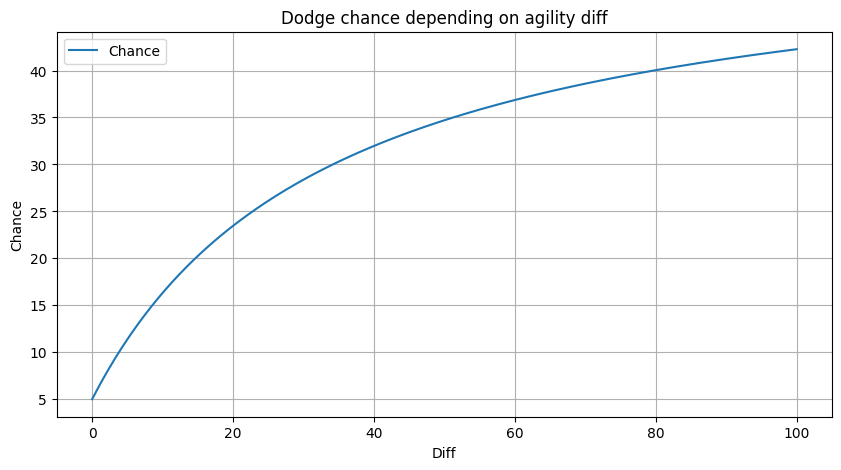

In [8]:
# в dodge и advantage_percent используется разновидности функции 1/x которая стремится к определённой границе,
# но никогда её не достигает

def calculate_dodge_chance(diff: int, offset_x=-34.15, base_chance=5) -> float:
    if diff > offset_x:
        return base_chance + max(-1707.69 / (diff - offset_x) + 50, 0)
    else:
        return base_chance

# Set the range for diff values
diff_values = np.linspace(0, 100, 300)
chance_values = [calculate_dodge_chance(diff) for diff in diff_values]

plt.figure(figsize=(10, 5))
plt.plot(diff_values, chance_values, label='Chance')
plt.title('Dodge chance depending on agility diff')
plt.xlabel('Diff')
plt.ylabel('Chance')
plt.grid(True)
plt.legend()
plt.show()



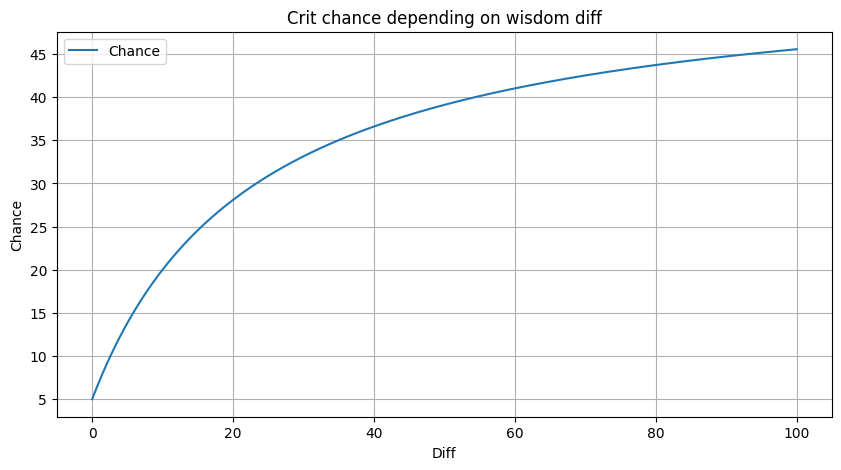

In [9]:
def calculate_crit_chance(diff: int, offset_x=-23.29, base_chance=5) -> float:
    if diff > offset_x:
        return base_chance + max(-1164.7 / (diff - offset_x) + 50, 0)
    else:
        return base_chance


# Set the range for diff values
diff_values = np.linspace(0, 100, 300)
chance_values = [calculate_crit_chance(diff) for diff in diff_values]

plt.figure(figsize=(10, 5))
plt.plot(diff_values, chance_values, label='Chance')
plt.title('Crit chance depending on wisdom diff')
plt.xlabel('Diff')
plt.ylabel('Chance')
plt.grid(True)
plt.legend()
plt.show()

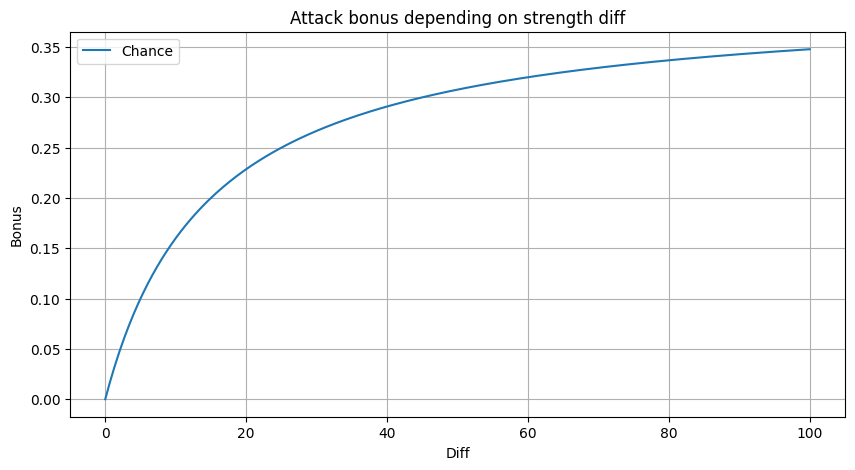

In [10]:
def calculate_attack_bonus(diff: int, offset_x=-15, base_bonus=0) -> float:
    if diff > offset_x:
        return base_bonus + max(-6 / (diff - offset_x) + 0.4, 0)
    else:
        return base_bonus

# Set the range for diff values
diff_values = np.linspace(0, 100, 300)
chance_values = [calculate_attack_bonus(diff) for diff in diff_values]

plt.figure(figsize=(10, 5))
plt.plot(diff_values, chance_values, label='Chance')
plt.title('Attack bonus depending on strength diff')
plt.xlabel('Diff')
plt.ylabel('Bonus')
plt.grid(True)
plt.legend()
plt.show()

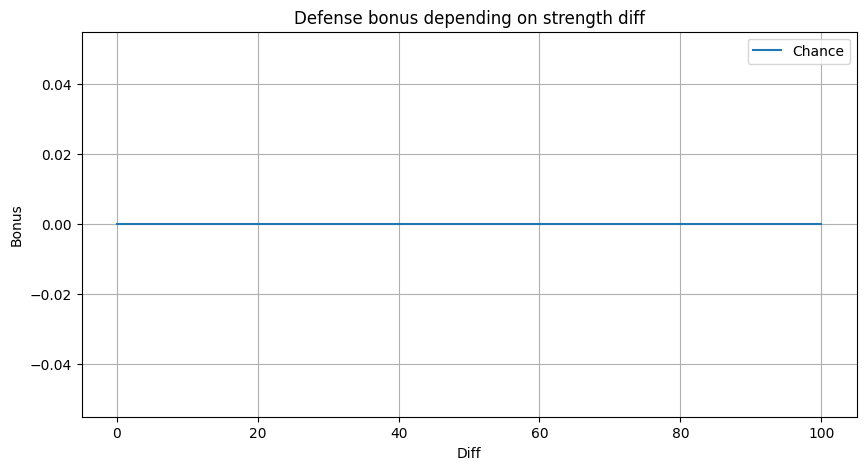

In [11]:
def calculate_defense_bonus(diff: int, offset_x=-15, base_bonus=0) -> float:
    return 0

# Set the range for diff values
diff_values = np.linspace(0, 100, 300)
chance_values = [calculate_defense_bonus(diff) for diff in diff_values]

plt.figure(figsize=(10, 5))
plt.plot(diff_values, chance_values, label='Chance')
plt.title('Defense bonus depending on strength diff')
plt.xlabel('Diff')
plt.ylabel('Bonus')
plt.grid(True)
plt.legend()
plt.show()

In [12]:
def dodge(agility1: int, agility2: int) -> bool:
    diff = agility1 - agility2
    result = random.randrange(100) < calculate_dodge_chance(diff)
    # print(agility1, chance, result)
    return result

def crit(wisdom1: int, wisdom2: int) -> float:
    diff = wisdom1 - wisdom2
    chance = calculate_crit_chance(diff)
    if random.randrange(100) < chance:
        # return calculate_crit_multiplier(diff)
        return 2
    else:
        return 1

def attack_multiplier(strength1: int, strength2: int) -> float:
    deviation = 0.1
    diff = strength1 - strength2
    return random.uniform(1 - deviation, 1 + deviation) + calculate_attack_bonus(diff)

def defense_multiplier(strength1: int, strength2: int) -> float:
    deviation = 0.1
    diff = strength1 - strength2
    return random.uniform(1 - deviation, 1 + deviation) + calculate_defense_bonus(diff)

def battle(pers1: Personage, pers2: Personage) -> bool:
    # Бой строится на принципе КНБ сила > ловкость > мудрость > сила
    turn1 = randrange(2) == 0
    bonus1 = pers1.advantage(pers2)
    bonus2 = pers2.advantage(pers1)
    # print("bonus 1", bonus1, "bonus 2", bonus2)
    pers1.total_hp = pers1.hp + 4 * pers1.defense * defense_multiplier(pers1.strength, pers1.strength)
    pers2.total_hp = pers2.hp + 4 * pers2.defense * defense_multiplier(pers2.strength, pers2.strength)
    while pers1.total_hp > 0 and pers2.total_hp > 0:
        if turn1:
            if not dodge(pers2.agility, pers1.agility):
                attack = pers1.attack \
                         * bonus1 \
                         * crit(pers1.wisdom, pers2.wisdom) \
                         * attack_multiplier(pers1.strength, pers2.strength)
                pers2.total_hp -= attack
        else:
            if not dodge(pers1.agility, pers2.agility):
                attack = pers2.attack *\
                         bonus2 *\
                         crit(pers2.wisdom, pers1.wisdom) *\
                         attack_multiplier(pers2.strength, pers1.strength)
                pers1.total_hp -= attack
        turn1 = not turn1
    # print(pers1.total_hp, pers2.total_hp)
    return pers1.total_hp > 0

In [13]:
repeat = 5000

## Считаем винрейты

In [14]:
wins = 0
min_hp = 10000
for _ in range(repeat):
    personage1 = pers_with_max_strength()
    personage2 = pers_with_max_agility()
    wins += 1 if battle(personage1, personage2) else 0
    min_hp = min(personage1.total_hp, min_hp)
print('Сила против ловкости: ', wins / repeat)
# print(min_hp)

Сила против ловкости:  0.8132


In [15]:
wins = 0
min_hp = 10000
for _ in range(repeat):
    personage1 = pers_with_max_agility()
    personage2 = pers_with_max_wisdom()
    wins += 1 if battle(personage1, personage2) else 0
    min_hp = min(personage1.hp, min_hp)
print('Ловкость против мудрости: ', wins / repeat)
# print(min_hp)

Ловкость против мудрости:  0.8152


In [16]:
wins = 0
min_hp = 10000
for _ in range(repeat):
    personage1 = pers_with_max_wisdom()
    personage2 = pers_with_max_strength()
    wins += 1 if battle(personage1, personage2) else 0
    min_hp = min(personage1.hp, min_hp)
print('Мудрость против силы: ', wins / repeat)
# print(min_hp)

Мудрость против силы:  0.8072


In [17]:
wins = 0
min_hp = 10000
for _ in range(repeat):
    personage1 = pers_with_max_wisdom()
    personage2 = default_pers()
    wins += 1 if battle(personage1, personage2) else 0
    min_hp = min(personage1.hp, min_hp)
print('Мудрость против дефолта: ', wins / repeat)

Мудрость против дефолта:  0.6036


In [18]:
wins = 0
min_hp = 10000
for _ in range(repeat):
    personage1 = pers_with_max_strength()
    personage2 = default_pers()
    wins += 1 if battle(personage1, personage2) else 0
    min_hp = min(personage1.hp, min_hp)
print('Сила против дефолта: ', wins / repeat)

Сила против дефолта:  0.6396


In [19]:
wins = 0
min_hp = 10000
for _ in range(repeat):
    personage1 = pers_with_max_agility()
    personage2 = default_pers()
    wins += 1 if battle(personage1, personage2) else 0
    min_hp = min(personage1.hp, min_hp)
print('Ловкость против дефолта: ', wins / repeat)

Ловкость против дефолта:  0.5942


In [20]:
wins = 0
min_hp = 10000
for _ in range(repeat):
    personage1 = Personage(500, 50, 20, 2, 5, 8)
    personage2 = Personage(500, 50, 20, 5, 5, 5)
    wins += 1 if battle(personage1, personage2) else 0
    min_hp = min(personage1.hp, min_hp)
print(wins / repeat)

0.4986


In [21]:
wins = 0
min_hp = 10000
for _ in range(repeat):
    personage1 = Personage(500, 50, 20, 9, 1, 5)
    personage2 = Personage(500, 50, 20, 5, 5, 5)
    wins += 1 if battle(personage1, personage2) else 0
    min_hp = min(personage1.hp, min_hp)
print(wins / repeat)

0.7128


In [22]:
wins = 0
min_hp = 10000
for _ in range(repeat):
    personage1 = Personage(500, 50, 20, 13, 1, 1)
    personage2 = Personage(500, 50, 20, 4, 1, 10)
    wins += 1 if battle(personage1, personage2) else 0
    min_hp = min(personage1.hp, min_hp)
print(wins / repeat)

0.2908


In [23]:
def calculate_power(pers):
    default = default_pers()
    crit_chance = calculate_crit_chance(pers.wisdom - default.wisdom) / 100
    dodge_chance = calculate_dodge_chance(pers.agility - default.agility) / 100
    attack_bonus = calculate_attack_bonus(pers.strength - default.strength)
    
    attack = pers.attack * (1 + attack_bonus)
    defense = (4 * pers.defense)
    tmp = pers.advantage(default)
    advantage = tmp if tmp > 1 else 1 / default.advantage(pers)
    
    return (pers.hp + defense) * (1 / (1 - dodge_chance)) * ((1 + crit_chance) * attack) * advantage

In [24]:
calculate_power(pers_with_max_strength())

40074.286990009496

In [25]:
calculate_power(pers_with_max_agility())

39081.90569029904

In [26]:
calculate_power(pers_with_max_wisdom())

39460.66877785395